In [ ]:
#742 Project - Theory of Machine Learning - Final Project
#Anjelika Klamp

#Popularity prediction of 8,412 Japanese Wikipedia articles.

In [1]:
#To ensure all output from a cell is shown.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Importing the necessary libraries

from math import sqrt
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
plt.usetex = True
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size

import re, unicodedata
import contractions
import nltk
from nltk.corpus import stopwords

import nagisa
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from scipy.stats import kstest
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

In [3]:
#Reading in the original data file from Kaggle in pickle format,
#with 8,412 observations.

j=pd.read_pickle('wiki')
j.head()

,article,views,text
0,メインページ,362562853,ようこそ\nウィキペディア - ウィキペディア日本語版 - 百科事典目次\n検索資料・ポータ...
1,星野源,10190763,星野 源（ほしの みなもと、1981年1月28日 - ）は、日本の音楽家、俳優、文筆家。埼玉...
2,真田信繁,9602104,真田 信繁（さなだ のぶしげ）は、安土桃山時代から江戸時代初期にかけての武将、大名。真田昌幸...
3,高橋一生,8571666,高橋 一生（たかはし いっせい、英字表記：Issey Takahashi、1980年12月9...
4,君の名は。,7788879,『君の名は。』（きみのなは、英: Your Name.）は、2016年に公開された新海誠監督...


In [4]:
#Function to remove numbers, replace contractions and lowercase for Latin based words
#(Romaji).

#def cleanup(text):
#    text = re.sub(r'\d+', '', text)
#    return contractions.fix(text).lower()

In [5]:
#j['clean'] = j['text'].apply(lambda x: cleanup(x))
#j['clean'].head(10)

In [6]:
#Tokenizing data using nagisa (based on a neural network).
#This step does not take long to run. However, its output
#in each cell then needs to be put back into string form
#so it can be fed into the vectorizer.

#j['j_parsed'] = j['clean'].apply(lambda x: nagisa.tagging(x))
#j['j_parsed'].head()

In [7]:
#Caution: This step takes a long time to run. Avoid running unnecessarily.
#Get the file from pre-processed pkl file instead!

#l=j.shape[0]

#for i in range(l):
#    p.append(' '.join(j['j_parsed'][i].words))

In [8]:
#This step only needed when preprocessing for the first time. 
#Saving is done in batches as the array is too big for the memory
#of a regular laptop after it has done the previous step.

#list_of_texts = pd.DataFrame(data=np.asarray(parsed[0:2000]))
#list_of_texts.to_pickle('./list_of_texts_whole1.pkl')
#list_of_texts = pd.DataFrame(data=np.asarray(parsed[2000:4000]))
#list_of_texts.to_pickle('./list_of_texts_whole2.pkl')
#list_of_texts = pd.DataFrame(data=np.asarray(parsed[4000:6000]))
#list_of_texts.to_pickle('./list_of_texts_whole3.pkl')
#list_of_texts = pd.DataFrame(data=np.asarray(parsed[6000:8000]))
#list_of_texts.to_pickle('./list_of_texts_whole4.pkl')
#list_of_texts = pd.DataFrame(data=np.asarray(parsed[8000:]))
#list_of_texts.to_pickle('./list_of_texts_whole5.pkl')

In [9]:
#Read in the 5 files with all pre-processed tokenized articles.

a=pd.read_pickle('list_of_texts_whole1.pkl')
b=pd.read_pickle('list_of_texts_whole2.pkl')
c=pd.read_pickle('list_of_texts_whole3.pkl')
d=pd.read_pickle('list_of_texts_whole4.pkl')
e=pd.read_pickle('list_of_texts_whole5.pkl')

a.shape
b.shape
c.shape
d.shape
e.shape

a.head()
b.head()
c.head()
d.head()
e.head()

(2000, 1)

(2000, 1)

(2000, 1)

(2000, 1)

(412, 1)

,0
0,よう こそ \n ウィキペディア - ウィキペディア 日本 語 版 - 百 ...
1,星野 源 ( ほしの みな もと 、 年 月 日 - ) は 、 日本 の ...
2,真田 信繁 ( さなだ のぶしげ ) は 、 安土 桃山 時代 から 江戸 時代 初...
3,高橋 一生 ( たか は し いっせい 、 英字 表記 : issey taka...
4,『 君 の 名 は 。 』 ( きみ の な は 、 英 : your name ....


,0
0,『 まれ 』 は 、 年 ( 平成 年度 ) 上 半期 に nhk 総合 テレビジョン ・ ...
1,超 特急 ( ちょうとっきゅう ) は 、 日本 の 音楽 グループ 、 ebidan の ...
2,『 シュガー ・ ラッシュ 』 ( 原題 : wreck-it ralph ) は 、 ...
3,吉田 美和 ( よし だ みわ 、 年 月 日 - ) は 、 dreams...
4,彼岸 ( ひがん ) と は 、 雑節 の 一 つ で 、 春分 ・ 秋分 を 中日 と し...


,0
0,三 又 又 三 ( み また またぞう 、 年 月 日 - ) は 、 日本...
1,アントーニ ・ ファン ・ レーウェン フック ( レーベン フック 、 antonie ...
2,アナーキー は 、 日本 の パン クロック バンド で ある 。 \n アルファベット で...
3,『 ソルト 』 ( salt ) は 、 年 の アメリカ 映画 で ある 。 監督 は フ...
4,"ヴィン ・ ディーゼル ( vin diesel , 年 月 日 - ) は..."


,0
0,三上 博史 ( みかみ ひろし 、 生 年 非 公表 ) は 、 日本 の 俳優 、...
1,細川 護熙 ( ほそかわ もりひろ 、 年 ( 昭和 年 ) 月日 - ) ...
2,サッカーベルギー 代表 ( オランダ 語 : belgisch voetbalelf...
3,"レオナ ・ ヘルムズリー ( leona helmsley , 年 月 日 - ..."
4,第 艦隊 ( だいなな かん たい 、 you.s. seventh fleet )...


,0
0,運慶 ( うんけい 、 生 年 不詳 - 貞応 年 月 日 ( 年 月 日 ) ) ...
1,成田 屋 ( なりたや ) は 、 歌舞伎 役者 の 屋号 。 歌舞伎 に おけ る 屋号 ...
2,\n = = 略歴 = = \n 年月 に 開催 さ れ た 『 seventeen...
3,サンマリノ 共和 国 \n serenissima repubblica di ...
4,『 プライム ニュース イブニング 』 ( ラテン 文字 表記 : prime ne...


In [10]:
#Concatenate the five dataframes and assign a title.

jw=pd.concat([a,b,c,d,e]).reset_index(drop=True)
jw.columns=['text']
jw.shape
jw.head()

(8412, 1)

,text
0,よう こそ \n ウィキペディア - ウィキペディア 日本 語 版 - 百 ...
1,星野 源 ( ほしの みな もと 、 年 月 日 - ) は 、 日本 の ...
2,真田 信繁 ( さなだ のぶしげ ) は 、 安土 桃山 時代 から 江戸 時代 初...
3,高橋 一生 ( たか は し いっせい 、 英字 表記 : issey taka...
4,『 君 の 名 は 。 』 ( きみ の な は 、 英 : your name ....


In [11]:
#Copy over the article and views columns from the original dataframe.

jw[['article','views']]=j[['article','views']]

In [12]:
jw.sort_values(by='views',ascending=False).head(10)

,text,article,views
0,よう こそ \n ウィキペディア - ウィキペディア 日本 語 版 - 百 ...,メインページ,362562853
1,星野 源 ( ほしの みな もと 、 年 月 日 - ) は 、 日本 の ...,星野源,10190763
2,真田 信繁 ( さなだ のぶしげ ) は 、 安土 桃山 時代 から 江戸 時代 初...,真田信繁,9602104
3,高橋 一生 ( たか は し いっせい 、 英字 表記 : issey taka...,高橋一生,8571666
4,『 君 の 名 は 。 』 ( きみ の な は 、 英 : your name ....,君の名は。,7788879
5,菅田 将暉 ( すだ まさき 、 年 月 日 - ) は 、 日本 の 俳優...,菅田将暉,7679480
6,吉岡 里帆 ( よしおか りほ 、 年 月 日 - ) は 、 日本 の 女...,吉岡里帆,7428176
7,one ok rock ( ワン オクロック ) は 、 日本 の ロック バンド ...,ONE_OK_ROCK,6950146
8,乃木坂 ( のぎざか フォーティーシックス 、 nogizaka ) は 、 日本 の ...,乃木坂46,6798768
9,『 re : ゼロ から 始める 異 世界 生活 』 ( リ ・ ゼロ から はじめる いせ...,Re:ゼロから始める異世界生活,6709283


In [13]:
#I remove the first row, as it is the Wikipedia welcome page,
#so will distort the analysis.

#Second popular page is about a Japanese musician and actor
#Hoshino.

jw = jw.iloc[1: , :]

In [14]:
#This is a list of Japanese stopwords commonly used in NLP.

stopwords_j = ['あそこ','あっ','あの','あのかた','あの人','あり','あります','ある','あれ','い','いう','います',
               'いる','う','うち','え','お','および','おり','おります','か','かつて','から','が','き','ここ',
               'こちら','こと','この','これ','これら','さ','さらに','し','しかし','する','ず','せ','せる',
               'そこ','そして','その','その他','その後','それ','それぞれ','それで','た','ただし','たち',
               'ため','たり','だ','だっ','だれ','つ','て','で','でき','できる','です','では','でも','と',
               'という','といった','とき','ところ','として','とともに','とも','と共に','どこ','どの',
               'な','ない','なお','なかっ','ながら','なく','なっ','など','なに','なら','なり','なる','なん',
               'に','において','における','について','にて','によって','により','による','に対して','に対する',
               'に関する','の','ので','のみ','は','ば','へ','ほか','ほとんど','ほど','ます','また','または',
               'まで','も','もの','ものの','や','よう','より','ら','られ','られる','れ','れる','を','ん','何',
               '及び','彼','彼女','我々','特に','私','私達','貴方','貴方方''ようこそ','ウィキペディア',
               'ウィキペディア日本語版','百科事典目次','検索資料','空白','補助記号']
len(stopwords_j)

140

In [15]:
#These are English-based stopwords from nltk corpus.
#Japanese contains words spelt in Latin characters mostly from 
#English, called Romaji. Although these are unlikely to be 
#stop words, it is still good practice to filter the data for
#stop words that are latin-character based. 

len(stopwords.words('english'))

179

In [16]:
#Here I compile the overall list of stopwords to feed into the 
#vectorizer.

#This is the union of the japanese stopword list,
#the English based stopwords, the list of stop words that are 
#specific to this dataset (Wikipedia specific stopwords) and
#punctuation characters. 

#It explicitely excludes any negative contractions to make sure 
#negatives are not deleted, as they are important to meaning of 
#the text. This step is just a precaution, as I already replaced
#any contractions that might have been in the text at the 
#preprocessing stage.

customlist_add = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

customlist_remove=['\n','\u3000','Wikipedia','wikipedia','・','FAQ','Main','Page','for','For','non',
                   'Japanese','speakers','learners','(',')','』','『']


sw = list(set(stopwords.words('english')) | set(stopwords_j) | set(customlist_remove) | set(list(string.punctuation)) 
          - set(customlist_add))       

In [17]:
len(sw)

366

In [18]:
n_features = 3000

In [19]:
#Using count vectorizer from SK Learn first to encode
#features vectors from the pre-processed tokenized text 
#data. I choose to keep the first 4000 features.

#In Japanese language, there are 2,000 single ideograms which are
#commonly used in day-to-day life, and combinations of these
#create more words. A too low number of features results 
#in poorly performing models.

#The vectorizer simultaneously removes all stopwords
#I had previously stored in sw.

vectorizer = CountVectorizer(stop_words=sw,max_features=n_features)
data_features_c = vectorizer.fit_transform(jw['text'])

data_features_c = data_features_c.toarray()     

C:\Users\AnjelikaKlamp\anaconda3\envs\torch\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['faq', 'japanese', 'main', 'page'] not in stop_words.
  % sorted(inconsistent)


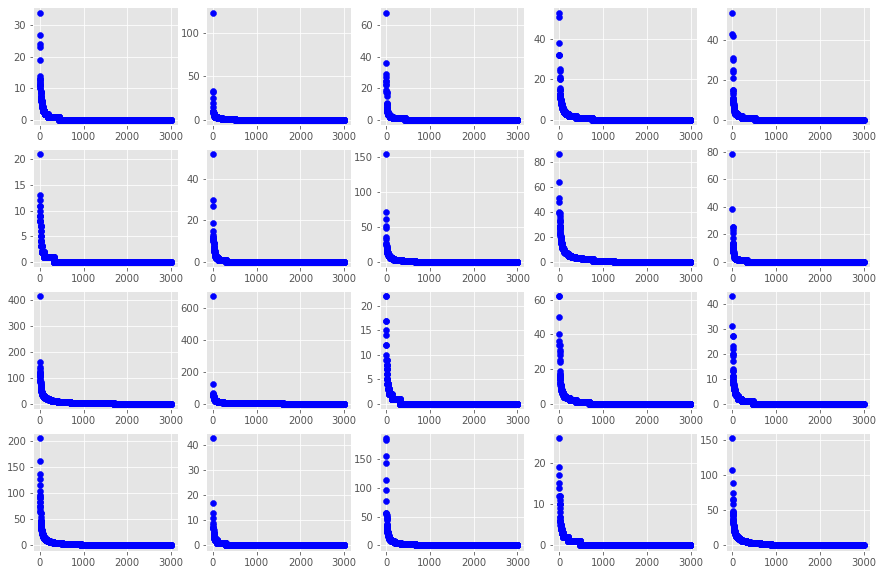

In [20]:
#Here I illustrate what features data looks like, sorted in decreasing order.
#This count vectorizer output, so it is count data, and the features matrix 
#is very sparse.

top = 20
x=range(n_features)

ax = plt.figure(figsize=(15,10))
pos = 1
for i in range(top):
    ax=plt.subplot(int(top/5), 5, pos)
    ax=plt.scatter(x,y=-np.sort(-data_features_c[i]), color ="b")
    pos += 1

In [21]:
-np.sort(-data_features_c[0])

array([34, 27, 24, ...,  0,  0,  0], dtype=int64)

In [22]:
#Checking feature array contents

np.sort(data_features_c.sum(axis=1))[:5]
np.sort(data_features_c.sum(axis=1))[3995:]
np.sort(data_features_c.sum(axis=0))[:5]
np.sort(data_features_c.sum(axis=0))[3995:]
np.sort(data_features_c,axis=0)[:5]
np.sort(data_features_c,axis=0)[3995:]
np.sort(data_features_c,axis=1)[:5]
np.sort(data_features_c,axis=1)[3995:]

array([1, 4, 5, 6, 6], dtype=int64)

array([  610,   610,   610, ..., 18416, 19933, 22978], dtype=int64)

array([1023, 1024, 1024, 1024, 1024], dtype=int64)

array([], dtype=int64)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 26, 159,  24, ...,  55,  31,  40],
       [ 31, 217,  26, ...,  67,  46,  42],
       [ 48, 231,  29, ...,  90,  48,  98]], dtype=int64)

array([[  0,   0,   0, ...,  24,  27,  34],
       [  0,   0,   0, ...,  32,  33, 123],
       [  0,   0,   0, ...,  29,  36,  68],
       [  0,   0,   0, ...,  38,  51,  53],
       [  0,   0,   0, ...,  42,  43,  54]], dtype=int64)

array([[  0,   0,   0, ...,  23,  32,  42],
       [  0,   0,   0, ...,  60, 119, 266],
       [  0,   0,   0, ...,  14,  18,  21],
       ...,
       [  0,   0,   0, ...,  43,  43,  78],
       [  0,   0,   0, ...,  32,  33, 765],
       [  0,   0,   0, ...,  15,  24,  54]], dtype=int64)

In [23]:
#I now run the Tfidf vectorizer with the same number of features

vectorizer = TfidfVectorizer(stop_words=sw,max_features=n_features)
data_features_tf = vectorizer.fit_transform(jw.iloc[:,0])

data_features_tf = data_features_tf.toarray()

data_features_tf.shape

(8411, 3000)

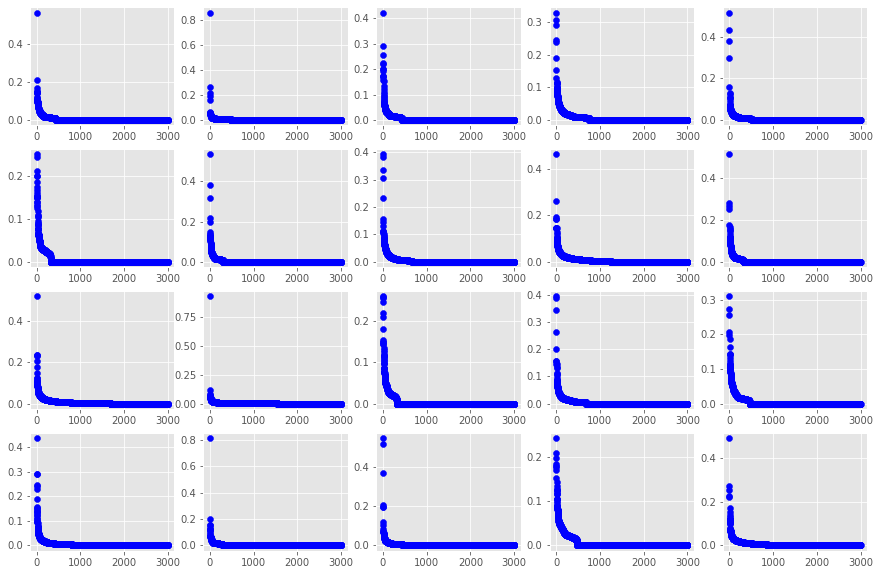

In [24]:
ax2 = plt.figure(figsize=(15,10))
pos = 1
for i in range(top):
    ax2=plt.subplot(int(top/5), 5, pos)
    ax2=plt.scatter(x,y=-np.sort(-data_features_tf[i]), color ="b")
    pos += 1

In [25]:
#Assigning 'views' as the dependent variable.
#This is a count variable.

y=np.array(jw['views'])

In [26]:
#The variance of our y variable is much larger than the mean, so at this 
#stage I am not sure is this is a Poisson variable.

#I check this further with a Kolmogorov-Smirnov test in a later step.

y_mean = y.mean()
y_var = y.var()
y_mean
y_var

422404.9700392343

575062576619.0491

In [27]:
q3, q1 = np.percentile(y, [75 ,25])
iqr = q3 - q1
iqr

313126.0

{'whiskers': [<matplotlib.lines.Line2D at 0x1c6786cca48>,
 'caps': [<matplotlib.lines.Line2D at 0x1c6786cc948>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c6786cc3c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c676e30548>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c676e30988>],
 'means': []}

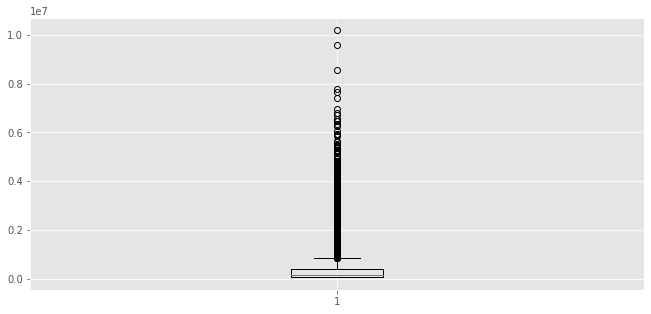

In [28]:
plt.boxplot(y, notch=None, vert=None, patch_artist=None, widths=None)

In [29]:
#The top 5 observations of y below.

#It is obvious that the largest value is a high multiple of the 
#second largest.

jw['views'].sort_values(ascending=False).head()

1    10190763
2     9602104
3     8571666
4     7788879
5     7679480
Name: views, dtype: int64

<AxesSubplot:>

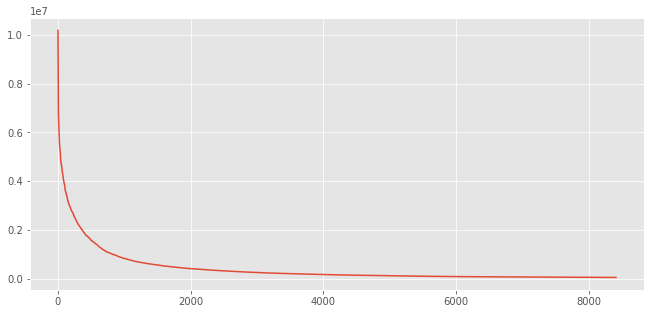

In [30]:
#The largest observation distorts the graph representation. So
#I impute it to the second largest value level, to be able to better 
#visualize the density.

jw['views'].plot()

In [31]:
#The two-sided Smirnov-Kolmogorov test tells us that the distribution of y is 
#statistically close to a Poisson distribution, as KS _statistic is above the
#critical value approximations suggested in "Advanced Statistics from an
#Elementary Point of View" by Michael Panik (see link below for approximation
#table).

#http://www.matf.bg.ac.rs/p/files/69-[Michael_J_Panik]_Advanced_Statistics_from_an_Elem(b-ok.xyz)-776-779.pdf

obs=jw.shape[0]
crit_denom=sqrt(obs)
crit_num=np.array([1.52,1.73,1.92,2.15,2.3])
lambdaPoisson = y_mean

ks_statistic_poisson, p_value_poisson = kstest(y.flatten(), 'poisson', args=(lambdaPoisson,0))

array = np.array([ks_statistic_poisson,p_value_poisson])
cv=(crit_num/crit_denom).reshape(1,-1)

conf=['0.80','0.90','0.95','0.98','0.99']

cv_result=pd.DataFrame(data=cv,index=['KS Critical Values Approximations'],columns=conf)

result = pd.DataFrame(data=array, index=['KS Statistic','pvalue'],columns=['Poisson'])

result
cv_result

,Poisson
KS Statistic,0.76543
pvalue,0.00000


,0.80,0.90,0.95,0.98,0.99
KS Critical Values Approximations,0.016574,0.018864,0.020935,0.023443,0.025079


{'whiskers': [<matplotlib.lines.Line2D at 0x1c60304e148>,
 'caps': [<matplotlib.lines.Line2D at 0x1c60304e788>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c603041a88>],
 'medians': [<matplotlib.lines.Line2D at 0x1c601e6a548>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c601e6aa08>],
 'means': []}

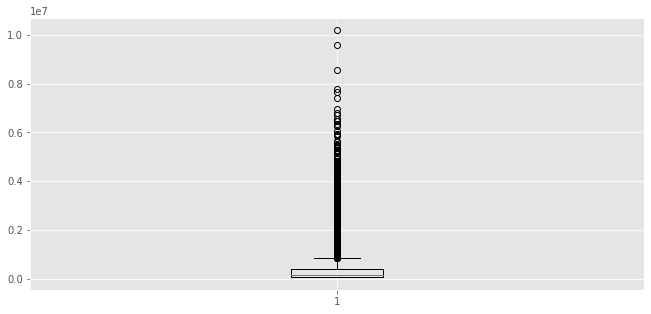

In [32]:
plt.boxplot(y, notch=None, vert=None, patch_artist=None, widths=None)

In [33]:
jw.shape

(8411, 3)

In [34]:
#I split the countvectorized x variables and our y variable ('data_features_c' and y) 
#into training and test set using a 70/30% split.

X_train_c, X_test_c, y_train, y_test = train_test_split(data_features_c, y, test_size=0.3, random_state=7)

In [35]:
#Similarly for tfidf vectorized data.

X_train_tf, X_test_tf, y_train, y_test = train_test_split(data_features_tf, y, test_size=0.3, random_state=7)

In [36]:
#I fit the Random Forest Regressor using 5 esitmators, and Poisson as the
#loss criterion with count vectorized data.

#Ideally I would have more estimators, but given the high dimensionality,
#this would require more computational resources.

RFR = RandomForestRegressor(n_estimators=5, criterion="poisson", n_jobs=4, random_state=7)
RFR_c = RFR.fit(X_train_c, y_train)
y_pred_rf_c_train = RFR_c.predict(X_train_c)
y_pred_rf_c_test = RFR_c.predict(X_test_c)

result = pd.DataFrame({'Model' : ['RF Count Vec'],
                       'Score' : [RFR_c.score(X_train_c,y_train)],
                       'RMSE train':[sqrt(mean_squared_error(y_train,y_pred_rf_c_train))],
                       'RMSE test':[sqrt(mean_squared_error(y_test,y_pred_rf_c_test))],
                       'Correl train':[np.corrcoef(y_train, y_pred_rf_c_train)[0,1]],
                       'Correl test':[np.corrcoef(y_test, y_pred_rf_c_test)[0,1]]})
result

,Model,Score,RMSE train,RMSE test,Correl train,Correl test
0,RF Count Vec,0.740763,388344.524829,808519.953239,0.862864,0.255408


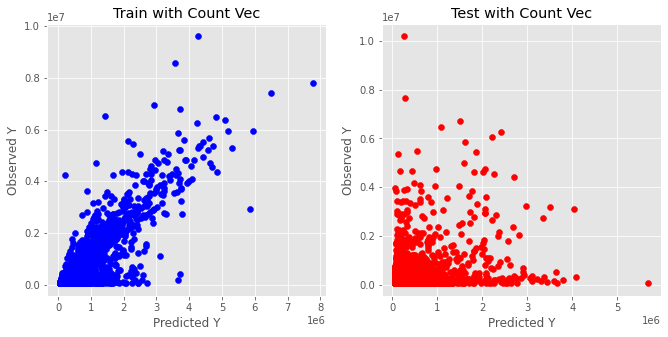

In [37]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_rf_c_train,y_train, color ="b")
ax=plt.title("Train with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_rf_c_test,y_test, color ="r")
ax=plt.title("Test with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [38]:
#I fit the Random Forest Regressor using 5 esitmators, and Poisson as the 
#loss criterion and the TFidf vectorized data.

RFR_tf = RFR.fit(X_train_tf, y_train)
y_pred_rf_tf_train = RFR_tf.predict(X_train_tf)
y_pred_rf_tf_test = RFR_tf.predict(X_test_tf)


result.loc[1] = ['RFR TFidf',RFR_tf.score(X_train_tf,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_rf_tf_train)),
                 sqrt(mean_squared_error(y_test,y_pred_rf_tf_test)),
                 np.corrcoef(y_train, y_pred_rf_tf_train)[0,1],
                 np.corrcoef(y_test, y_pred_rf_tf_test)[0,1]]
result

,Model,Score,RMSE train,RMSE test,Correl train,Correl test
0,RF Count Vec,0.740763,388344.524829,808519.953239,0.862864,0.255408
1,RFR TFidf,0.713867,407992.789713,855129.259180,0.853702,0.089408


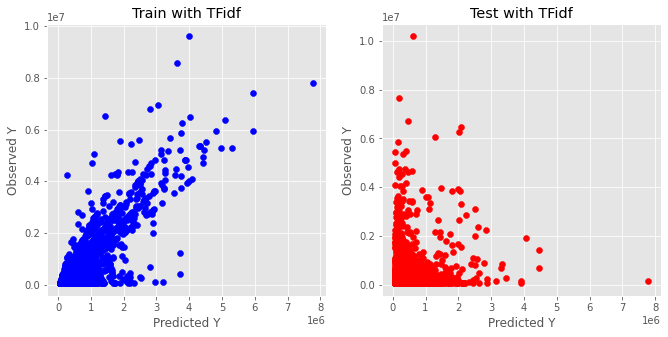

In [39]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_rf_tf_train,y_train, color ="b")
ax=plt.title("Train with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_rf_tf_test,y_test, color ="r")
ax=plt.title("Test with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [40]:
KNN = KNeighborsRegressor()
KNN_c = KNN.fit(X_train_c, y_train)
y_pred_knn_c_train = KNN_c.predict(X_train_c)
y_pred_knn_c_test = KNN_c.predict(X_test_c)


result.loc[2] = ['KNN Count Vec',KNN_c.score(X_train_c,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_knn_c_train)),
                 sqrt(mean_squared_error(y_test,y_pred_knn_c_test)),
                 np.corrcoef(y_train, y_pred_knn_c_train)[0,1],
                 np.corrcoef(y_test, y_pred_knn_c_test)[0,1]]
result

,Model,Score,RMSE train,RMSE test,Correl train,Correl test
0,RF Count Vec,0.740763,388344.524829,808519.953239,0.862864,0.255408
1,RFR TFidf,0.713867,407992.789713,855129.259180,0.853702,0.089408
2,KNN Count Vec,0.398913,591339.618132,721439.287773,0.656349,0.307511


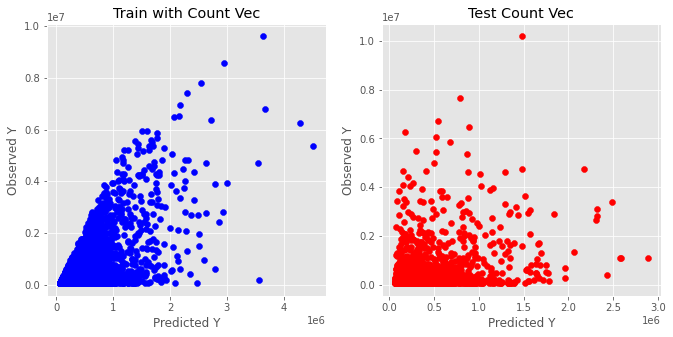

In [41]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_knn_c_train,y_train, color ="b")
ax=plt.title("Train with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_knn_c_test,y_test, color ="r")
ax=plt.title("Test Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [42]:
KNN_tf = KNN.fit(X_train_tf, y_train)
y_pred_knn_tf_train = KNN_tf.predict(X_train_tf)
y_pred_knn_tf_test = KNN_tf.predict(X_test_tf)


result.loc[3] = ['KNN TFidf',KNN_tf.score(X_train_tf,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_knn_tf_train)),
                 sqrt(mean_squared_error(y_test,y_pred_knn_tf_test)),
                 np.corrcoef(y_train, y_pred_knn_tf_train)[0,1],
                 np.corrcoef(y_test, y_pred_knn_tf_test)[0,1]]
result

,Model,Score,RMSE train,RMSE test,Correl train,Correl test
0,RF Count Vec,0.740763,388344.524829,808519.953239,0.862864,0.255408
1,RFR TFidf,0.713867,407992.789713,855129.259180,0.853702,0.089408
2,KNN Count Vec,0.398913,591339.618132,721439.287773,0.656349,0.307511
3,KNN TFidf,0.214016,676200.049506,790183.503033,0.498241,0.256738


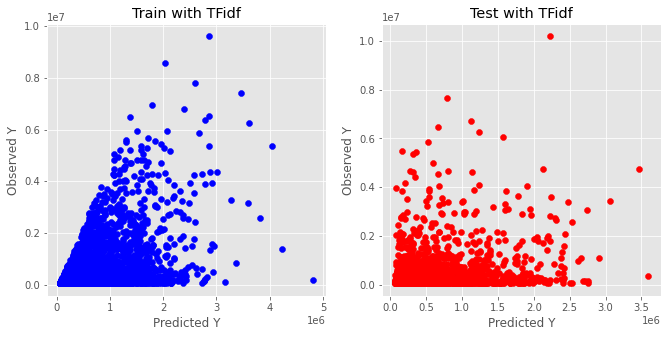

In [43]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_knn_tf_train,y_train, color ="b")
ax=plt.title("Train with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_knn_tf_test,y_test, color ="r")
ax=plt.title("Test with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [44]:
SVR = SVR(C=1.0, epsilon=0.2)
SVR_c = SVR.fit(X_train_c, y_train)
y_pred_SVR_c_train = SVR_c.predict(X_train_c)
y_pred_SVR_c_test = SVR_c.predict(X_test_c)


result.loc[4] = ['SVR Count Vec',SVR_c.score(X_train_c,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_SVR_c_train)),
                 sqrt(mean_squared_error(y_test,y_pred_SVR_c_test)),
                 np.corrcoef(y_train, y_pred_SVR_c_train)[0,1],
                 np.corrcoef(y_test, y_pred_SVR_c_test)[0,1]]
result

,Model,Score,RMSE train,RMSE test,Correl train,Correl test
0,RF Count Vec,0.740763,388344.524829,808519.953239,0.862864,0.255408
1,RFR TFidf,0.713867,407992.789713,855129.259180,0.853702,0.089408
2,KNN Count Vec,0.398913,591339.618132,721439.287773,0.656349,0.307511
3,KNN TFidf,0.214016,676200.049506,790183.503033,0.498241,0.256738
4,SVR Count Vec,-0.122866,808225.312665,789618.131840,0.271997,0.245428


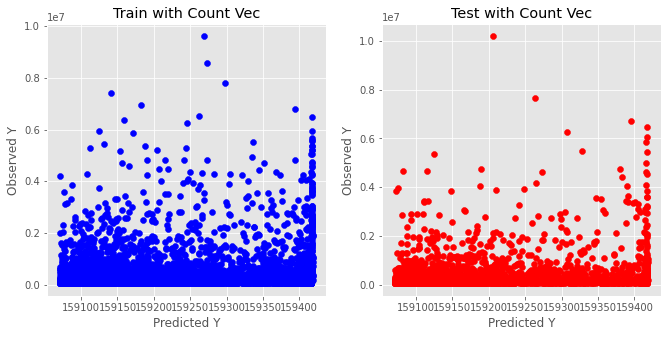

In [45]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_SVR_c_train,y_train, color ="b")
ax=plt.title("Train with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_SVR_c_test,y_test, color ="r")
ax=plt.title("Test with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [46]:
SVR_tf = SVR.fit(X_train_tf, y_train)
y_pred_SVR_tf_train = SVR_tf.predict(X_train_tf)
y_pred_SVR_tf_test = SVR_tf.predict(X_test_tf)


result.loc[5] = ['SVR TFidf',SVR_tf.score(X_train_tf,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_SVR_tf_train)),
                 sqrt(mean_squared_error(y_test,y_pred_SVR_tf_test)),
                 np.corrcoef(y_train, y_pred_SVR_tf_train)[0,1],
                 np.corrcoef(y_test, y_pred_SVR_tf_test)[0,1]]
result

,Model,Score,RMSE train,RMSE test,Correl train,Correl test
0,RF Count Vec,0.740763,388344.524829,808519.953239,0.862864,0.255408
1,RFR TFidf,0.713867,407992.789713,855129.259180,0.853702,0.089408
2,KNN Count Vec,0.398913,591339.618132,721439.287773,0.656349,0.307511
3,KNN TFidf,0.214016,676200.049506,790183.503033,0.498241,0.256738
4,SVR Count Vec,-0.122866,808225.312665,789618.131840,0.271997,0.245428
5,SVR TFidf,-0.122987,808268.916560,789658.802153,0.247885,0.215466


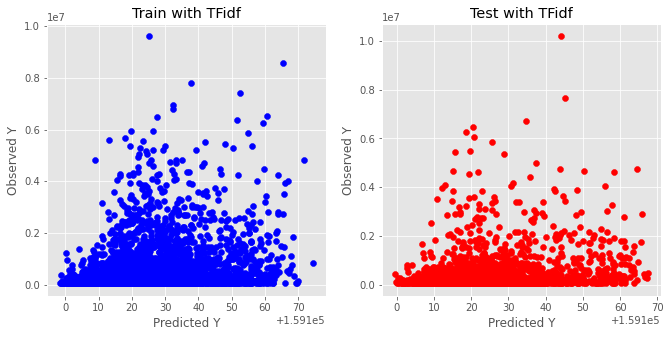

In [47]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_SVR_tf_train,y_train, color ="b")
ax=plt.title("Train with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_SVR_tf_test,y_test, color ="r")
ax=plt.title("Test with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [48]:
gs_c = {  'C': [0.01, 0.05, 0.5, 1],
        'epsilon': [0.05, 0.1, 0.2],
        'kernel': ['rbf', 'poly']
        }

search = GridSearchCV(SVR_c, param_grid = gs_c, cv = 10)
search.fit(X_train_c, y_train)

KeyboardInterrupt: 

In [ ]:
search.best_params_

In [ ]:
SVR_gs = SVR(C=1.0, epsilon=0.1,kernel='poly')
SVR_gs_c = SVR_gs.fit(X_train_c, y_train)
y_pred_SVR_gs_c_train = SVR_gs_c.predict(X_train_c)
y_pred_SVR_gs_c_test = SVR_gs_c.predict(X_test_c)


result.loc[6] = ['SVR GS Count Vec',SVR_gs_c.score(X_train_c,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_SVR_gs_c_train)),
                 sqrt(mean_squared_error(y_test,y_pred_SVR_gs_c_test)),
                 np.corrcoef(y_train, y_pred_SVR_gs_c_train)[0,1],
                 np.corrcoef(y_test, y_pred_SVR_gs_c_test)[0,1]]
result

In [ ]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_SVR_gs_c_train,y_train, color ="b")
ax=plt.title("Train with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_SVR_gs_c_test,y_test, color ="r")
ax=plt.title("Test with Count Vec")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()

In [ ]:
gs_tf = {  'C': [0.01, 0.05, 0.5, 1],
        'epsilon': [0.05, 0.1, 0.2],
        'kernel': ['rbf', 'poly']
        }

search = GridSearchCV(SVR_tf, param_grid = gs_tf, cv = 10)
search.fit(X_train_tf, y_train)

In [ ]:
search.best_params_

In [ ]:
SVR_gs = SVR(C=1.0, epsilon=0.05,kernel='poly')
SVR_gs_tf = SVR_gs.fit(X_train_tf, y_train)
y_pred_SVR_gs_tf_train = SVR_gs_tf.predict(X_train_tf)
y_pred_SVR_gs_tf_test = SVR_gs_tf.predict(X_test_tf)


result.loc[7] = ['SVR GS TFidf',SVR_gs_tf.score(X_train_tf,y_train),
                 sqrt(mean_squared_error(y_train,y_pred_SVR_gs_tf_train)),
                 sqrt(mean_squared_error(y_test,y_pred_SVR_gs_tf_test)),
                 np.corrcoef(y_train, y_pred_SVR_gs_tf_train)[0,1],
                 np.corrcoef(y_test, y_pred_SVR_gs_tf_test)[0,1]]
result

In [ ]:
ax=plt.subplot(1, 2, 1)
ax=plt.scatter(y_pred_SVR_gs_tf_train,y_train, color ="b")
ax=plt.title("Train with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

ax=plt.subplot(1, 2, 2)
ax=plt.scatter(y_pred_SVR_gs_tf_test,y_test, color ="r")
ax=plt.title("Test with TFidf")
ax=plt.xlabel('Predicted Y')
ax=plt.ylabel('Observed Y')

plt.show()